# Evolution on rugged adaptive landscapes
## Obolski, Ram & Hadany
## Key Issues Review for Reports on Progress in Physics, 2017

This notebook contains text and Python code as the supporting material for

> Obolski, Ram & Hadany (2017) Evolution on rugged adaptive landscapes, Reports on Progress in Physics.

The most updated version of this notebook is on [GitHub](https://github.com/yoavram/UnderTheRug).

To run the notebook you will need Python (v.3.5), Jupyter notebook (v.4.3), NumPy (v1.11), Matplotlib (v.2.0), Seaborn (v.0.7), and Cython (v.0.25); see the [README](https://github.com/yoavram/UnderTheRug/blob/master/README.md) for more instructions.

# Notebook 1: Evolutionary simulations on rugged landscapes

The notebook includes code to load fitness landscape data, simulate evolution on the landscape using a Wright-Fisher model, and visualize the results of simulations.

In [1]:
%matplotlib inline
import os
import collections
import itertools
import glob
import gzip
try:
    import ujson as json
except ImportError:
    print("Can't import ujson, using json instead")
    import json

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper', font_scale=2)

# Empirical fitness landscape: *A. niger*

The fitness landscape is composed of 8 loci and 186 combinations of mutations in these loci that were viable and had measurable fitness in the fungus [_Aspergillus niger_](http://en.wikipedia.org/wiki/Aspergillus_niger).

## Read fitness landscape file
The [fitness landscape file](https://gitlab.com/yoavram/EvolRugAdaptLand2016/blob/master/Franke2011.csv) was downloaded from [Franke et al. 2011](http://www.ploscompbiol.org/article/info%3Adoi%2F10.1371%2Fjournal.pcbi.1002134) and converted to CSV using [Tabula](http://tabula.nerdpower.org/).

Start by downloading it if it's not already on the local filesystem.

In [2]:
def download(filename, url):
    if not os.path.exists(filename):
        import urllib.request
        urllib.request.urlretrieve(url, filename)
    return os.path.exists(filename)

landscape_filename = 'Franke2011.csv'
landscape_url = 'https://github.com/yoavram/EvolRugAdaptLand2016/raw/master/Franke2011.csv'
download(landscape_filename, landscape_url)

True

In [3]:
!head $landscape_filename

Mutation number,fwn,arg,pyr,leu,phe,lys,oli,crn,Relative W
0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0.751
1,0,1,0,0,0,0,0,0,0.773
1,0,0,1,0,0,0,0,0,0.698
1,0,0,0,1,0,0,0,0,0.757
1,0,0,0,0,1,0,0,0,0.826
1,0,0,0,0,0,1,0,0,m
1,0,0,0,0,0,0,1,0,0.598
1,0,0,0,0,0,0,0,1,0.628


Read the file using Pandas, and convert `m` values in the `Relative W` column (fitness) to 0, as they mean "missing".

In [4]:
data = pd.read_csv(landscape_filename)
missing_W = data['Relative W'] == 'm'
data.loc[missing_W, 'Relative W'] = 0
data['Relative W'] = data['Relative W'].astype(float)
data.head()

,Mutation number,fwn,arg,pyr,leu,phe,lys,oli,crn,Relative W
0,0,0,0,0,0,0,0,0,0,1.000
1,1,1,0,0,0,0,0,0,0,0.751
2,1,0,1,0,0,0,0,0,0,0.773
3,1,0,0,1,0,0,0,0,0,0.698
4,1,0,0,0,1,0,0,0,0,0.757


Create a new column called `genotype` with the bit string of each genotype.

In [5]:
loci_columns = 'fwn 	arg 	pyr 	leu 	phe 	lys 	oli 	crn'.split() # as copied from the table above
data['genotype'] = data[loci_columns].apply(
    lambda row: str.join('', map(str, row)), axis=1)
data.head()

,Mutation number,fwn,arg,pyr,leu,phe,lys,oli,crn,Relative W,genotype
0,0,0,0,0,0,0,0,0,0,1.000,00000000
1,1,1,0,0,0,0,0,0,0,0.751,10000000
2,1,0,1,0,0,0,0,0,0,0.773,01000000
3,1,0,0,1,0,0,0,0,0,0.698,00100000
4,1,0,0,0,1,0,0,0,0,0.757,00010000


In [6]:
fitness = collections.defaultdict(float)
for i, row in data.iterrows():
    fitness[row['genotype']] = row['Relative W']

assert fitness['00000000'] == 1

genotypes = tuple(fitness.keys())
assert '00000000' in genotypes

Define the `hamming` function for distance between genotypes:

In [7]:
def hamming(g1, g2='00000000'):
    assert len(g1) == len(g2)
    return sum(g1i != g2i for g1i, g2i in zip(g1, g2))

assert hamming('00000000', '10000000') == 1
assert hamming('00000000', '10001010') == 3

def plot_matrix(M):
    plt.imshow(M, norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)

## Simulation
Standard Wright-Fisher simulation (Otto & Day, 2007, ch. 13.4) of asexual, haploid, constant size populations with non-overlapping generations. Selection, determined by the fitness landscape; mutaion, bi-directional and uniform rate; and random genetic drift.

In [8]:
n = len(next(iter(fitness)))
mu = 1e-4 # mutation rate as in Szendro et al. 2013 
m = len(genotypes)

We define the mutation matrix $u$ used to compute the linear transformation:
$$
p'_k = (1-\sum_{j \ne k}{M_{j,k}})p_k + \sum_{j \ne k}{M_{k,j} p_j}
$$
where $u_{i,j}$ is the mutation rate from genotype $j$ to $i$.

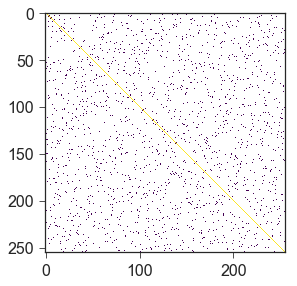

In [9]:
def mutation_matrix(genotypes, mu):
    m = len(genotypes)
    M = np.diag([1.0] * m)
    for i in range(m):
        for j in range(m):    
            if hamming(genotypes[i], genotypes[j]) == 1:
                M[j, i] = mu
                M[i, i] -= mu

    assert np.allclose(M.sum(axis=1), 1)
    return M

M = mutation_matrix(genotypes, mu)
plot_matrix(M)

The selection matrix is used to compute the linear part of the natural selection transformation:
$$
p'_k = \frac{\omega_k p_k}{\bar{\omega}}
$$
as well as to find the mean population fitness by calculating the inner product with $p$:
$$
\bar{\omega} = \sum_{k}{\omega_k p_k}
$$

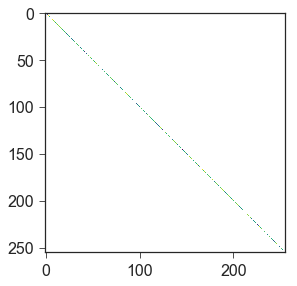

In [10]:
def selection_matrix(genotypes, fitness):
    return np.diag([fitness[g] for g in genotypes])

S = selection_matrix(genotypes, fitness)
plot_matrix(S)

We then calculate a single matrix for mutation and the linear part of selection.

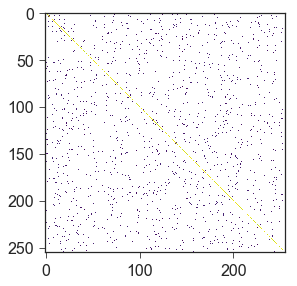

In [11]:
E = M.dot(S)
assert E.shape == (m ,m)
plot_matrix(E)

Random genetic drift is simulated by drawing a random vector from a multinomial distribution with parameters $N$ (population size) and $p$ (genotype frequencies after mutation and selection).

We simulate adaptation of the population, starting from a population of the maladapted genotype `11011111` and evolving until 99% of population is fully adapted (fitness = 1). At each generation we apply the selection, mutation and drift operators, and keep tab of the adjusted frequencies.

In [12]:
N = 1e9
generations = 2**15

def adaptation(genotypes, start='11011111', finish='00000000', verbose=True):    
    g0i = genotypes.index(start) # index of starting point. 11011111 is also used in Szendro2013
    if verbose:
        print("starting genotype:", genotypes[g0i])
        print("starting fitness:", fitness[genotypes[g0i]])
    g1i = genotypes.index(finish) # index of most adapted genotype
    
    # p is the frequencies vector
    p = np.empty((m, generations), dtype=float)
    p[:, 0] = 0
    p[g0i, 0] = 1.0
    
    # pom holds the index of the most frequent genotype at each time point
    pom = [p[:, 0].argmax()]
    
    # W holds the population mean fitness at each time point
    W = np.empty(generations, dtype=float)
    W[0] = S.diagonal() @ p[:, 0]  # mean fitness calculation

    for k in range(1, generations):
        if verbose and k % (generations / 10) == 0: 
            print(k, end=" ")
        p[:, k] = E @ p[:, k - 1]  # selection and mutation are deterministic
        p[:, k] /= p[:, k].sum()  # normalize frequencies vector
        p[:, k] = np.random.multinomial(N, p[:, k]) / N  # random genetic drift is stochastic

        W[k] = (S.diagonal().dot(p[:, k]))  # mean fitness calculation
        
        # update pom if most frequent changed
        if p[:, k].argmax() != pom[-1]:     
            pom.append(p[:, k].argmax())
        
        # break if reached fixation
        if p[g1i, k] > 0.99:
            break
    return k, p, W, pom

k, p, W, pom = adaptation(genotypes, verbose=True)
print("# generations:", k)

starting genotype: 11011111
starting fitness: 0.456
# generations: 838


### Path of maxium (POM)

We follow the path of maxium (see [Szendro et al. 2013](http://www.ncbi.nlm.nih.gov/pubmed/23267075)) during the population evolution - this is the sequence of the most frequent genotype at each generation.

We can see that although 7 mutations accumulated during the adaptation, some of them never reached a high frequency on their own, and there were only 4 genotypes that were the most frequent at any time point.

In [13]:
print([gi for gi in pom])
print( [genotypes[gi] for gi in pom])
print( [sum(map(int, genotypes[gi])) for gi in pom])
print( [fitness[genotypes[gi]] for gi in pom])

[37, 187, 161, 7, 3]
['11011111', '11011101', '00001101', '10001000', '00000000']
[7, 6, 3, 2, 0]
[0.456, 0.841, 0.928, 0.973, 1.0]


The following shows the dynamics of the population mean fitness over time on the top, and the frequencies of the most frequent genotype at the bottom. 

Note how each step of the adaptation is smaller (in terms of change in population mean fitness) and wider apart (in terms of time between changes in fitness). This is because the effective increase in fitness due to each additional mutation is smaller (diminishing effects).

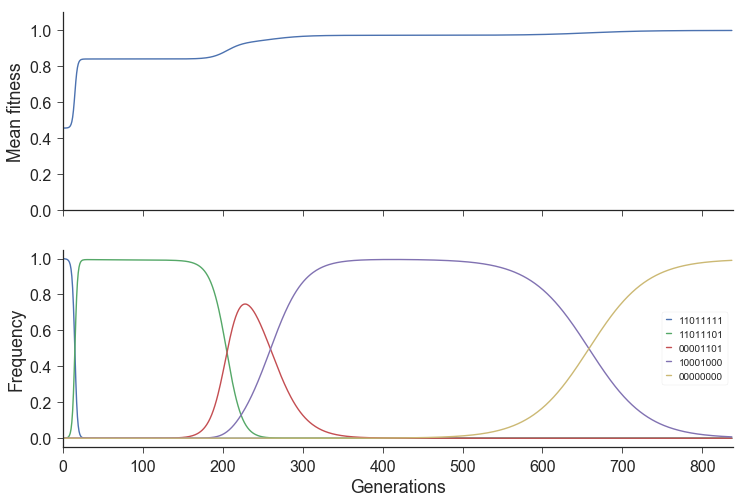

In [14]:
def plot_adaptation(k, p, W, pom, genotypes, ax=None):
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    ax[0].plot(W[:k])
    ax[0].set(xlabel='', ylabel='Mean fitness', ylim=(0, 1.1), xlim=(0, k))

    ax[1].plot(p[pom, :k].T)
    ax[1].set(xlabel='Generations', ylabel='Frequency')
    ax[1].legend([genotypes[x] for x in pom], loc='center right', frameon=True, fontsize=10, handlelength=0.5)

    sns.despine()
    return ax
    
plot_adaptation(k, p, W, pom, genotypes);

### Line of descent (LOD)

Line of descent ([Ostman et al. 2012](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=3223680); [Szendro et al. 2013](http://www.ncbi.nlm.nih.gov/pubmed/23267075)) is the sequence of genotypes that are the ancestors of the final population, assuming that the entire final population has a single phylogeny (likely in cases of strong sweeps, as we have in this asexual populations). We determine the LOD after the simulation ended using backward propagation: we draw a random individual in generation `t`, then draw its ancestor from generation `t-1` according to the genotype frequencies in generation `t-1`, the fitness of the different genotypes, and the mutation rates. This process is the reverse of the above simulation.

In [15]:
def build_lod(p):
    t = k - 1
    lod = np.empty(k, dtype=int)
    lod[t] = p[:, t].argmax() # start with the most frequent genotype
    while t > 0:
        gi = lod[t]
        assert S.diagonal()[gi] > 0
        t -= 1
        q = p[:, t] * M[gi, :] * S.diagonal() # calculate parent probabilities
        assert q.sum() > 0, gi
        q /= q.sum()  # normalize probabilities vector
        assert (q[S.diagonal() == 0] == 0).all(), q[S.diagonal() == 0]
        gj = np.random.multinomial(1, q).argmax()  # draw a single parent & find its genotype index
        assert S.diagonal()[gj] > 0
        lod[t] = gj
    return lod

lod = build_lod(p)

We also want a clean LOD in which we remove consecutive duplicates. We write a [Cython](http://cython.org/) function to do this faster (Cython is an optimising static compiler for Python; we get ~4-fold increase of speed due to static type definitions).

In [16]:
%load_ext Cython

In [17]:
%%cython
import numpy as np
cimport numpy as np

def clean_lod(np.ndarray[long] lod):
    cdef np.ndarray[char] take = np.ones_like(lod, dtype=np.uint8)
    cdef int i = 1
    cdef int n = len(lod)
    
    for i in range(1, n):
        if lod[i] == lod[i - 1]:
            take[i] = 0

    return lod[take.view(dtype=np.bool)]

We see that the clean LOD has the 8 genotypes of the evolutionary trajectory (bridged by the 7 accumulated mutations), in contrast with the POM that only had 4 genotypes.

In [18]:
cleaned_lod = clean_lod(lod)
clean_lod(lod)

array([ 37, 187, 162, 204, 155,   7,  15,   3])

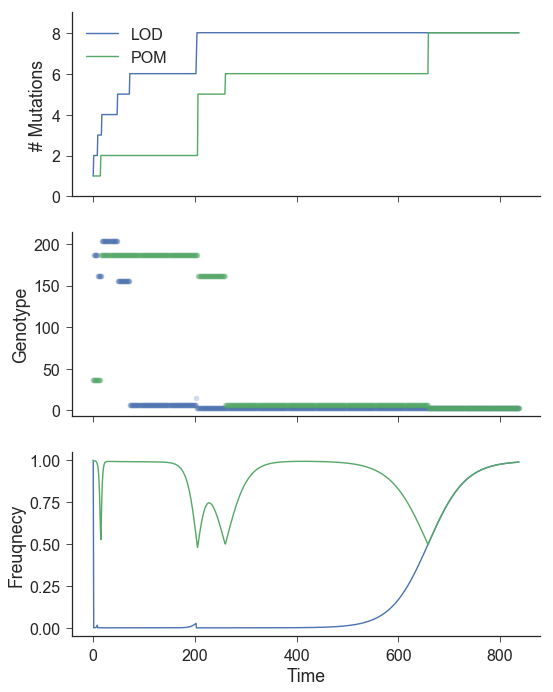

In [19]:
def plot_lod(k, p, W, pom, genotypes):
    fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

    ax[0].plot([n - sum(map(int, genotypes[x])) for x in lod], label='LOD')
    ax[0].plot([n - sum(map(int, genotypes[x])) for x in p[:,:k].argmax(axis=0)], label='POM')
    ax[0].set(ylabel='# Mutations', ylim=(0, n+1))
    ax[0].legend(loc='upper left')

    ax[1].plot(lod, 'o', alpha=0.25, label='LOD')
    ax[1].plot(p[:,:k].argmax(axis=0), 'o', alpha=0.25, label='POM')
    ax[1].set(ylabel='Genotype')

    ax[2].plot([p[lod[t], t] for t in range(k)])
    ax[2].plot(p[:,:k].max(axis=0))
    ax[2].set(xlabel='Time', ylabel='Freuqnecy')

    fig.tight_layout()
    sns.despine()
    
plot_lod(k, p, W, pom, genotypes)

### Adaptive peaks

Before proceeding, let's have a closer look at this adaptive landscape. 
Peaks are genotypes that are local maxima of the adaptive landscape.

In [20]:
def flip_bit(bs, i):
    return '{:08b}'.format(int(bs, base=2) ^ 2**i)

assert flip_bit('10111110', 0) == '10111111'
assert flip_bit('10111110', 1) == '10111100'
assert flip_bit('00111110', 3) == '00110110'

In [21]:
def find_peaks(genotypes, fitness):
    peaks = collections.OrderedDict(fitness)
    for g in genotypes:
        for i in range(len(g)):
            g2 = flip_bit(g, i)
            if fitness[g2] > fitness[g]:
                peaks.pop(g)
                break
    return peaks

peaks = find_peaks(genotypes, fitness)
peak_distances = [hamming(p) for p in peaks]
print("Number of peaks:", len(peaks))

Number of peaks: 15


So out of 256 possible genotypes, 15 are peaks, or local maxima. That's almost 6%.

### Adaptive valleys

Valleys are genotypes that are local minima.

In [22]:
def find_valleys(genotypes, fitness):
    valleys = collections.OrderedDict(fitness)
    for g in genotypes:
        for i in range(len(g)):
            g2 = flip_bit(g, i)        
            if fitness[g2] and fitness[g2] < fitness[g]:
                valleys.pop(g)
                break
    return valleys

valleys = find_valleys(genotypes, fitness)
valley_distances = [hamming(p) for p in valleys]
print( "Number of valleys:", len(valleys))

Number of valleys: 84


84 out of 256 genotypes are local minima - almost a third! However, this includes the non-vital genotypes.

Let's plot all the peaks and valleys.

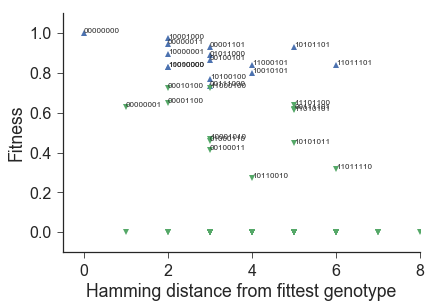

In [23]:
def plot_peaks_valleys(peaks, valleys):
    peak_distances = [hamming(p) for p in peaks]
    valley_distances = [hamming(p) for p in valleys]
    
    fig, ax = plt.subplots()
    ax.plot(peak_distances, tuple(peaks.values()), '^')
    for x,y,z in zip(peak_distances, list(peaks.values()), list(peaks.keys())):
        ax.text(x, y, z, fontsize=8)

    ax.plot(valley_distances, tuple(valleys.values()), 'v')
    for x,y,z in zip(valley_distances, list(valleys.values()), list(valleys.keys())):
        if y > 0:
            ax.text(x, y, z, fontsize=8)
    ax.set(xlim=(-0.5, n), 
           ylim=(-0.1, 1.1),
           xlabel="Hamming distance from fittest genotype",
           ylabel="Fitness"
    )
    sns.despine()
    return fig, ax

plot_peaks_valleys(peaks, valleys);

## Landscape simulation plot

We will now run many simulations to get some statistics on frequent trajectories (LODs).

In [24]:
repetitions = 1000
results = (adaptation(genotypes, verbose=False) for _ in range(repetitions))

In [25]:
lods = [None] * repetitions
cleaned_lods = [None] * repetitions
for i, (k, p, W, pom ) in enumerate(results):    
    lods[i] = build_lod(p)
    cleaned_lods[i] = clean_lod(lods[i])

In [26]:
genotype_freq = np.zeros(m)

for lod in lods:
    for gi in lod:
        genotype_freq[gi] += 1

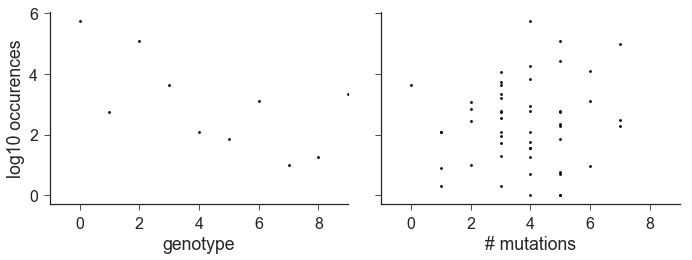

In [27]:
def plot_genotype_freq(genotype_freq):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,4))

    ax[0].plot(
        np.log10(genotype_freq[genotype_freq > 0]), 
        '.k'
    )
    ax[0].set(
        xlabel='genotype',
        ylabel='log10 occurences',
        xlim=(-1, n + 1),
    )

    ax[1].plot(
        [hamming(genotypes[gi]) for gi, _ in enumerate(genotype_freq[genotype_freq > 0])], 
        np.log10(genotype_freq[genotype_freq > 0]), 
        '.k'
    )

    ax[1].set(
        xlabel='# mutations',
        xlim=(-1, n + 1),
    )

    fig.tight_layout()
    sns.despine()
    return fig, (ax)

plot_genotype_freq(genotype_freq);

We can see in the above figure, on the left, the four genotypes that were very frequent and several other genotypes that were frequent, but we can see that this plot if very sparse, despite the log scale on the y-axis; most genotypes never reached even a moderate frequency.

On the right we can see the genetic distances at which the populations spent most of their time. It seems like the populations spent a lot of time 5 mutations away from the global peak and less and less time at closer distances.

Next we calculate the frequency of each trajectory/ancestry across all simulations. We see that two trajectories account for 25% of the simulations.

In [28]:
genotype_freq = {genotypes[gi]:c for gi, c in enumerate(genotype_freq)}

In [29]:
lods_freq = collections.defaultdict(int)
for lod in cleaned_lods:
    lods_freq[tuple(lod)] += 1

top_lods_freq = sorted(lods_freq.items(), key=lambda x: x[1], reverse=True)[:5]
for lod, cnt in top_lods_freq:
    print(lod, cnt / repetitions)

(37, 187, 162, 204, 155, 7, 10, 3) 0.162
(37, 187, 162, 204, 155, 7, 15, 3) 0.1
(37, 187, 162, 122, 161, 197, 10, 3) 0.083
(37, 187, 162, 122, 161, 245, 4, 3) 0.074
(37, 187, 162, 74, 155, 7, 10, 3) 0.04


Finally we produce a plot that summarizes the adaptive landscape topology and the characteristics of adaptation on this landscape.

In [30]:
def plot_landscape(top_lods_freq, genotypes, genotype_freq, fitness, peaks, valleys, ax=None):    
    linestyles = 'solid dashed dashdot dotted'.split()
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))
    else:
        fig = ax.figure
    
    # most frequent LOD
    for lod, count in top_lods_freq[:len(linestyles)]:
        linestyle = linestyles.pop(0)
        ax.plot(
            [hamming(genotypes[gi]) for gi in lod], 
            [fitness[genotypes[gi]] for gi in lod], 
            linewidth=5, 
            color='#404040', 
            linestyle=linestyle,
            label='{:.2f}'.format(count / repetitions)
        )

    # markers for genotypes
    size = lambda g: 3.5 + 1.0*genotype_freq[g] / repetitions
    ax.scatter(
        [hamming(g) for g, w in fitness.items() if w and g not in peaks and g not in valleys], 
        [w for g, w in fitness.items() if w and g not in peaks and g not in valleys], 
        c='k', 
        marker='o', 
        s=[size(g) for g, w in fitness.items() if w and g not in peaks and g not in valleys]
    )
    ax.scatter(
        [hamming(g) for g, w in fitness.items() if w and g in peaks], 
        [w for g, w in fitness.items() if w and g in peaks], 
        c='k', 
        marker='^', 
        s=[size(g) for g, w in fitness.items() if w and g in peaks]
    )
    ax.scatter(
        [hamming(g) for g, w in fitness.items() if w and g in valleys], 
        [w for g, w in fitness.items() if w and g in valleys], 
        c='k', 
        marker='v', 
        s=[size(g) for g, w in fitness.items() if w and g in valleys]
    )

    # lines for mutations
    for g, w in ((g, w) for g, w in fitness.items() if w ):    
        for i in range(len(g)):
            g2 = flip_bit(g, i)
            if fitness[g2] > 0:
                ax.arrow(
                    hamming(g), 
                    fitness[g], 
                    hamming(g2) - hamming(g), 
                    fitness[g2] - fitness[g], 
                    width=0.001,
                    head_width=0,
                    color='#404040', 
                    alpha=0.5, 
                    linestyle='dotted'
                )

    min_w = min((w for w in fitness.values() if w))
    max_w = max((w for w in fitness.values() if w))
    ax.set(
        ylim=(min_w * 0.9, max_w * 1.1),
        xlim=(-0.5, n + 0.5),
        xlabel="# Mutations",
        ylabel="Fitness"
    )
    ax.legend(title="Frequency", loc='lower left', frameon=True)
    return ax

Franke2011.tif,pdf


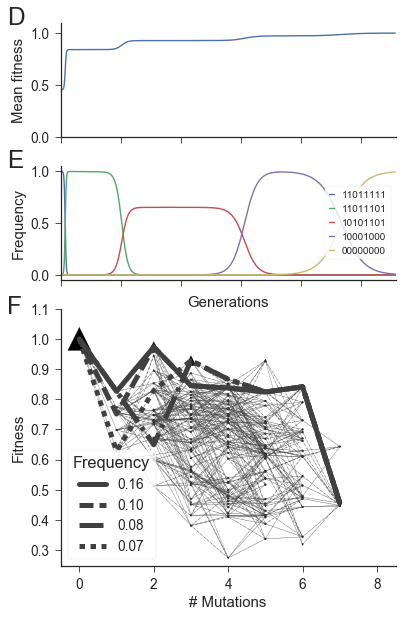

In [31]:
sns.set_context('paper', font_scale=1.7)
fig = plt.figure(figsize=(6, 10)) 
gs = mpl.gridspec.GridSpec(nrows=4, ncols=1, hspace=0.25)
ax = [plt.subplot(gs[0, 0])]
ax += [plt.subplot(gs[1, 0], sharex=ax[0]), plt.subplot(gs[2:, 0])]

plot_adaptation(k, p, W, pom, genotypes, ax=ax[:2])
ax[0].set_xticklabels([])
plot_landscape(top_lods_freq, genotypes, genotype_freq, fitness, peaks, valleys, ax=ax[2])

panel_label_size=plt.rcParams[ 'axes.titlesize']*1.5
ax[0].annotate('D', (-0.16, 0.98), xycoords='axes fraction', fontsize=panel_label_size)
ax[1].annotate('E', (-0.16, 0.98), xycoords='axes fraction', fontsize=panel_label_size)
ax[2].annotate('F', (-0.16, 0.98), xycoords='axes fraction', fontsize=panel_label_size)

sns.despine()
fig.savefig(landscape_filename[:-4] + '.tif', dpi=300)
fig.savefig(landscape_filename[:-4] + '.pdf', dpi=300, paper_size='A4')
print(landscape_filename[:-4] + '.tif,pdf')

In [32]:
print ('mu = 1e', np.log10(mu), 'N = 1e', np.log10(N), 'generations = 2^', np.log2(generations))

mu = 1e -4.0 N = 1e 9.0 generations = 2^ 15.0


# Empricial fitness landscape: TEM

The fitness landscape is composed of 5 loci in the TEM gene and all 32 combinations of mutations in these loci. Fitness is measured as MIC ([minimum inhibitory concentration](https://en.wikipedia.org/wiki/Minimum_inhibitory_concentration)) in the bacteria [Escherichia_coli](https://en.wikipedia.org/wiki/Escherichia_coli).

## Read fitness landscape file
The [fitness landscape file](https://gitlab.com/yoavram/EvolRugAdaptLand2016/blob/master/Weinreich2006.csv) was downloaded from [Weinreich et al. 2006](http://www.sciencemag.org/content/suppl/2006/04/05/312.5770.111.DC1/Weinreich_SOM.pdf) and converted to CSV using [Tabula](http://tabula.nerdpower.org/).

Start by downloading it if it's not already on the local filesystem.

In [33]:
landscape_filename = 'Weinreich2006.csv'
landscape_url = 'https://github.com/yoavram/EvolRugAdaptLand2016/raw/master/Weinreich2006.csv'
download(landscape_filename, landscape_url)

True

In [34]:
!head $landscape_filename

g4205a,A42G,E104K,M182T,G238S,Replicate 1,Replicate 2,Replicate 3
,,,,,0.088,0.088,0.088
,,,,+ ,1.4,1.4,1.4
,,,+ ,,0.088,0.063,0.063
,,,+ ,+ ,32,32,32
,,+ ,,,0.13,0.088,0.18
,,+ ,,+ ,360,360,360
,,+ ,+ ,,0.18,0.13,0.18
,,+ ,+ ,+ ,360,360,360
,+ ,,,,0.088,0.088,0.088


Read the dataset:

In [35]:
data = pd.read_csv(landscape_filename)
data.head()

,g4205a,A42G,E104K,M182T,G238S,Replicate 1,Replicate 2,Replicate 3
0,NaN,NaN,NaN,NaN,NaN,0.088,0.088,0.088
1,NaN,NaN,NaN,NaN,+,1.400,1.400,1.400
2,NaN,NaN,NaN,+,NaN,0.088,0.063,0.063
3,NaN,NaN,NaN,+,+,32.000,32.000,32.000
4,NaN,NaN,+,NaN,NaN,0.130,0.088,0.180


Convert + to 1 and NaN to 0:

In [36]:
loci_columns = 'g4205a 	A42G 	E104K 	M182T 	G238S'.split() # as copied from the table above
genotypes = data[loci_columns].as_matrix()
genotypes[pd.isnull(genotypes)] = 0
genotypes[genotypes != 0] = 1
data['g4205a 	A42G 	E104K 	M182T 	G238S'.split()] = genotypes
data.head()

,g4205a,A42G,E104K,M182T,G238S,Replicate 1,Replicate 2,Replicate 3
0,0,0,0,0,0,0.088,0.088,0.088
1,0,0,0,0,1,1.400,1.400,1.400
2,0,0,0,1,0,0.088,0.063,0.063
3,0,0,0,1,1,32.000,32.000,32.000
4,0,0,1,0,0,0.130,0.088,0.180


Average resistance data:

In [37]:
fitness = data['Replicate 1 	Replicate 2 	Replicate 3'.split(' 	')]
data['Resistance'] = fitness.mean(axis=1)
data['Absolute W'] = np.log10(1 + data['Resistance']) # arbitrary transformation of resistance to fitness
data['Relative W'] = data['Absolute W'] / data['Absolute W'].max()
data.head()

,g4205a,A42G,E104K,M182T,G238S,Replicate 1,Replicate 2,Replicate 3,Resistance,Absolute W,Relative W
0,0,0,0,0,0,0.088,0.088,0.088,0.088000,0.036629,0.010138
1,0,0,0,0,1,1.400,1.400,1.400,1.400000,0.380211,0.105237
2,0,0,0,1,0,0.088,0.063,0.063,0.071333,0.029925,0.008283
3,0,0,0,1,1,32.000,32.000,32.000,32.000000,1.518514,0.420305
4,0,0,1,0,0,0.130,0.088,0.180,0.132667,0.054102,0.014975


Create fitness map:

In [38]:
data['genotype'] = data[loci_columns].apply(
    lambda row: str.join('', map(str, row)), axis=1)
data.tail()

,g4205a,A42G,E104K,M182T,G238S,Replicate 1,Replicate 2,Replicate 3,Resistance,Absolute W,Relative W,genotype
27,1,1,0,1,1,360.0,360.0,360.0,360.000000,2.557507,0.707884,11011
28,1,1,1,0,0,1.4,2.8,2.0,2.066667,0.486667,0.134703,11100
29,1,1,1,0,1,1500.0,2100.0,1500.0,1700.000000,3.230704,0.894216,11101
30,1,1,1,1,0,1.4,1.4,1.4,1.400000,0.380211,0.105237,11110
31,1,1,1,1,1,4100.0,4100.0,4100.0,4100.000000,3.612890,1.000000,11111


In [39]:
fitness = collections.defaultdict(float)
for i, row in data.iterrows():
    fitness[row['genotype']] = row['Relative W']

assert fitness['11111'] == 1

genotypes = tuple(fitness.keys())
assert '11111' in genotypes

In [40]:
def hamming(g1, g2='11111'):
    assert len(g1) == len(g2)
    return sum(g1i != g2i for g1i, g2i in zip(g1, g2))

Define variables for the simulations:

In [41]:
n = len(next(iter(fitness)))
mu = 1e-8 # mutation rate
m = len(genotypes)

Next we construct the selection and mutation matrices, as above.

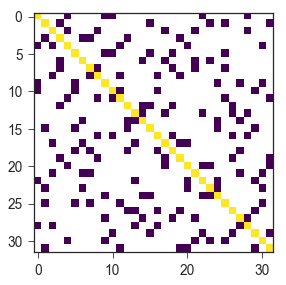

In [42]:
M = mutation_matrix(genotypes, mu)
plot_matrix(M)

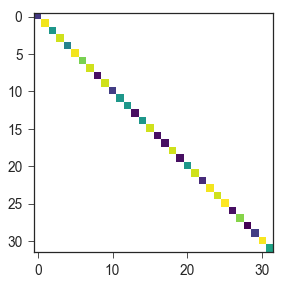

In [43]:
S = selection_matrix(genotypes, fitness)
plot_matrix(S)

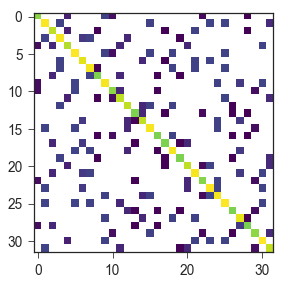

In [44]:
E = M.dot(S)
assert E.shape == (m ,m)
plot_matrix(E)

## Simulation

We start the simulations from the genotype farthest away from the optimum.

In [45]:
k, p, W, pom = adaptation(genotypes, start='00000', finish='11111', verbose=True)
print("# generations:", k)

starting genotype: 00000
starting fitness: 0.010138392727488304
# generations: 735


The POM includes 6 genotypes, each with a single additional mutation - this is in contrast to the _A. niger_ simulations that only had 4 genotypes at the POM, despite fixing more mutations. This can be attributed to the fact the the TEM landscape is much smoother then the _A. niger_ landscape, with a single peak (we analyse the peaks below).

In [46]:
print([gi for gi in pom])
print( [genotypes[gi] for gi in pom])
print( [sum(map(int, genotypes[gi])) for gi in pom])
print( [fitness[genotypes[gi]] for gi in pom])

[13, 14, 24, 23, 30, 25]
['00000', '00001', '00101', '01101', '01111', '11111']
[0, 1, 2, 3, 4, 5]
[0.010138392727488304, 0.10523743208102061, 0.7078840942357442, 0.9196034932062663, 0.9583873159477904, 1.0]


Again, each adaptation step is smaller and takes more time, and fixation is very deterministic once the invading genotype managed to avoid fixation by random genetic drift.

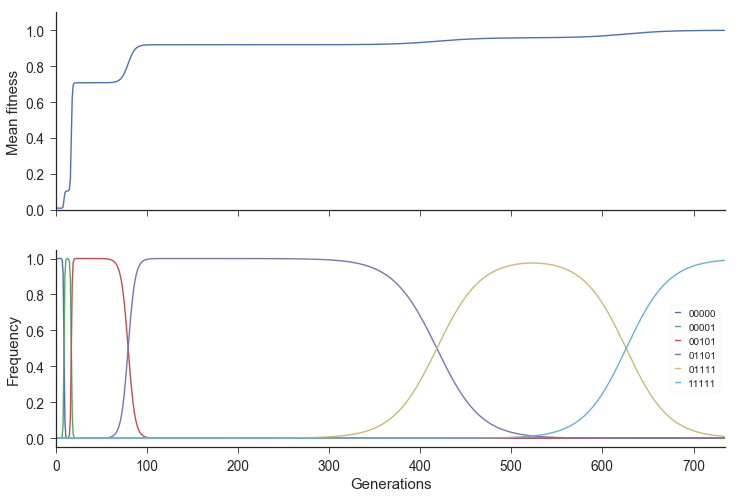

In [47]:
plot_adaptation(k, p, W, pom, genotypes);

### Creating the LOD

In [48]:
lod = build_lod(p)
lod[:5]

array([13, 14, 14, 14, 14])

In [49]:
cleaned_lod = clean_lod(lod)
clean_lod(lod)

array([13, 14, 24, 23, 30, 25])

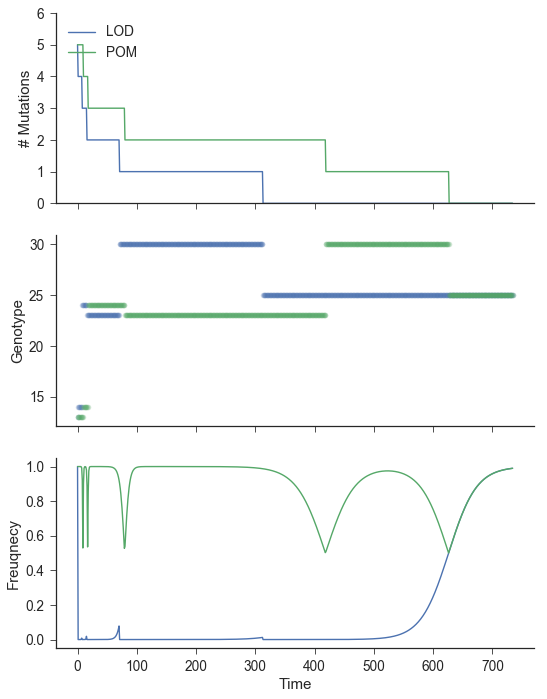

In [50]:
plot_lod(k, p, W, pom, genotypes)

## Peaks and valleys

In [51]:
def flip_bit(bs, i):
    return '{:05b}'.format(int(bs, base=2) ^ 2**i)

assert flip_bit('11110', 0) == '11111'
assert flip_bit('11110', 1) == '11100'
assert flip_bit('11110', 3) == '10110'

This landscape only has a single peak - so it's much less rugged than the _A. niger_ landscape - and has 5/32 valleys, all with very low fitness.

In [52]:
peaks = find_peaks(genotypes, fitness)
peak_distances = [hamming(p) for p in peaks]
print("Number of peaks:", len(peaks))

Number of peaks: 1


In [53]:
valleys = find_valleys(genotypes, fitness)
valley_distances = [hamming(p) for p in valleys]
print( "Number of valleys:", len(valleys))

Number of valleys: 5


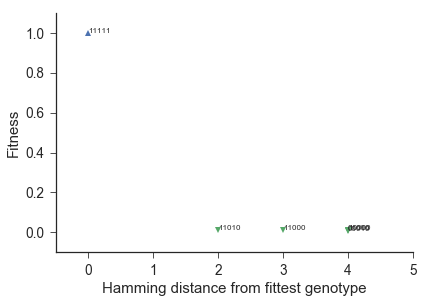

In [54]:
def plot_peaks_valleys(peaks, valleys):
    peak_distances = [hamming(p) for p in peaks]
    valley_distances = [hamming(p) for p in valleys]
    
    fig, ax = plt.subplots()
    ax.plot(peak_distances, tuple(peaks.values()), '^')
    for x,y,z in zip(peak_distances, list(peaks.values()), list(peaks.keys())):
        ax.text(x, y, z, fontsize=8)

    ax.plot(valley_distances, tuple(valleys.values()), 'v')
    for x,y,z in zip(valley_distances, list(valleys.values()), list(valleys.keys())):
        if y > 0:
            ax.text(x, y, z, fontsize=8)
    ax.set(xlim=(-0.5, n), 
           ylim=(-0.1, 1.1),
           xlabel="Hamming distance from fittest genotype",
           ylabel="Fitness"
    )
    sns.despine()
    return fig, ax

plot_peaks_valleys(peaks, valleys);

## Simulation plot

In [55]:
repetitions = 1000
results = (adaptation(genotypes, '00000', '11111', verbose=False) for _ in range(repetitions))

In [56]:
lods = [None] * repetitions
cleaned_lods = [None] * repetitions
for i, (k, p, W, pom ) in enumerate(results):    
    lods[i] = build_lod(p)
    cleaned_lods[i] = clean_lod(lods[i])

In [57]:
genotype_freq = np.zeros(m)

for lod in lods:
    for gi in lod:
        genotype_freq[gi] += 1

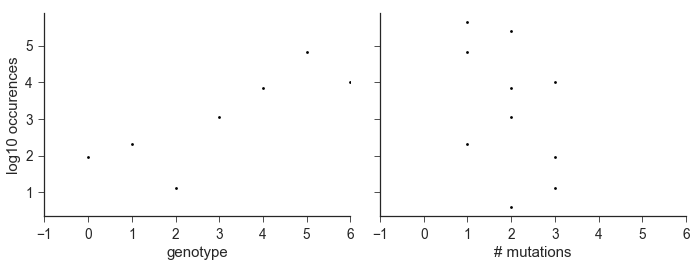

In [58]:
plot_genotype_freq(genotype_freq);

In [59]:
genotype_freq = {genotypes[gi]:c for gi, c in enumerate(genotype_freq)}

In [60]:
lods_freq = collections.defaultdict(int)
for lod in cleaned_lods:
    lods_freq[tuple(lod)] += 1

top_lods_freq = sorted(lods_freq.items(), key=lambda x: x[1], reverse=True)[:5]
for lod, cnt in top_lods_freq:
    print(lod, cnt / repetitions)

(13, 14, 24, 23, 30, 25) 0.976
(13, 14, 6, 23, 30, 25) 0.023
(13, 14, 27, 9, 5, 25) 0.001


Weinreich2006.tif,pdf


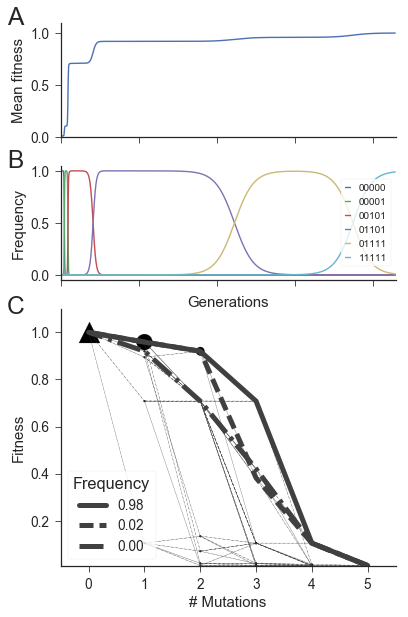

In [63]:
fig = plt.figure(figsize=(6, 10)) 
gs = mpl.gridspec.GridSpec(nrows=4, ncols=1, hspace=0.25)
ax = [plt.subplot(gs[0, 0])]
ax += [plt.subplot(gs[1, 0], sharex=ax[0]), plt.subplot(gs[2:, 0])]

plot_adaptation(k, p, W, pom, genotypes, ax=ax[:2])
ax[0].set_xticklabels([])
plot_landscape(top_lods_freq, genotypes, genotype_freq, fitness, peaks, valleys, ax=ax[2])

panel_label_size=plt.rcParams[ 'axes.titlesize']*1.5
ax[0].annotate('A', (-0.16, 0.98), xycoords='axes fraction', fontsize=panel_label_size)
ax[1].annotate('B', (-0.16, 0.98), xycoords='axes fraction', fontsize=panel_label_size)
ax[2].annotate('C', (-0.16, 0.98), xycoords='axes fraction', fontsize=panel_label_size)

sns.despine()
fig.savefig(landscape_filename[:-4] + '.tif', dpi=300)
fig.savefig(landscape_filename[:-4] + '.pdf', dpi=300, paper_size='A4')
print(landscape_filename[:-4] + '.tif,pdf')

In [62]:
print('mu = 1e', np.log10(mu), 'N = 1e', np.log10(N), 'generations = 2^', np.log2(generations))

mu = 1e -8.0 N = 1e 9.0 generations = 2^ 15.0


#### Merge the two empirical landscape figures

To merge the two figures into one, we use [`convert`](https://imagemagick.org/script/convert.php).
Install on mac with homebrew: `brew install imagemagick`.

In [76]:
!convert Weinreich2006.tif Franke2011.tif +append empirical_landscapes.tif

If you require PDF, you can use [`pdfjam`](http://freecode.com/projects/pdfjam).
Install on mac with homebrew: `brew install homebrew/tex/pdfjam`.

In [64]:
!pdfjam --nup 2x1 --landscape --outfile empirical_landscapes.pdf Weinreich2006.pdf Franke2011.pdf

          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /Users/yoavram/homebrew/bin/pdfjam --nup '2x1' --landscape --outfile empirical_landscapes.pdf -- Weinreich2006.pdf - Franke2011.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'empirical_landscapes.pdf'.


# Two-locus adaptive landscape

The next plot explores adaptive peak shifts in a two-loci rugged landscape. Two bi-allelic loci give us four genotypes:
- _ab_ with fitness 1; this is the initial genotype in the population
- _aB_ and _Ab_ are the adaptive valleys with fitnes _1-s = 0.95_
- _AB_ is the adaptive peak with _1+sH = 1.1_. This is the final destination of adaptation.

We simulate a single adaptation to show the dynamics, as well as collate results from many simulation to explore the statsitcs of the adaptaion event. The simulation code is in `simulation.py` which is modified from [simulation2.py](https://github.com/yoavram/ruggedsim/blob/master/stochastic/simulation2.py); both the original code and the collated data are from from [Ram & Hadany, _PRSB_ 2016](http://rspb.royalsocietypublishing.org/content/281/1792/20141025.abstract). The data is deposited on [dryad](http://dx.doi.org/10.5061/dryad.3066j). We use the dataset labeld `adaptation_weak_mutation_15JUL14.csv.gz (424.1 Kb)`.

In [2]:
s = 0.05 # selection coefficient
H = 2 # double mutant advantage 
U = 0.0004 # mutation rate, Wielgoss et al. 2011
u = U * 0.2 / 1000 
beta=0.0002 # beneficial mutation rate, beta=0.0002, Gordo, Perfeito, and Sousa 2011
N = pop_size = 1e6 # population size
G = 25 # max number of deleterious mutations
pi = 1 # see original paper (Ram & Hadany, 2013); however pi = 1 means you can ignore this value
tau = 1.0 # same as previous line

red,blue,green = sns.color_palette('Set1', 3)

Run a simulation and save it's result to files. **Run it again** if it resulted in extinction.

In [3]:
import simulation

In [79]:
ps, Ws = simulation.run(N, s, H, U, beta, G, pi, tau)

Starting simulation
Tick 0
MSB reached at tick 5000 with mean fitness 0.9996
Tick 1000000
Tick 2000000
Tick 3000000
Tick 4000000
Tick 5000000
Tick 6000000
Tick 7000000
Double mutant appeared at tick 7778083 with mean fitness 0.9996
AB/0 1e-06, AB/1 0, AB/2 0, AB/3 0
Fixation at tick 7778364 with mean fitness 1.1 and AB frequency 1
AB/0 0.9918, AB/1 0.008159, AB/2 1.6e-05, AB/3 0
Simulation finished, 7778364 ticks


In [80]:
ps = np.array(ps)
Ws = np.array(Ws)

In [81]:
with open('Ws.npz', 'wb') as f:
    Ws = np.save(f, Ws)
with open('ps.npz', 'wb') as f:
    ps = np.save(f, ps)

Load simulation results from file:

In [4]:
with open('Ws.npz', 'rb') as f:
    Ws = np.load(f)
with open('ps.npz', 'rb') as f:
    ps = np.load(f)

Load data from the Ram & Hadany 2013 paper:

In [5]:
with open('df_all_15JUL14.csv') as f:
    df = pd.read_csv(f)
df = df[df.s == s]
df = df[df.tau==1]

Plot everything together:

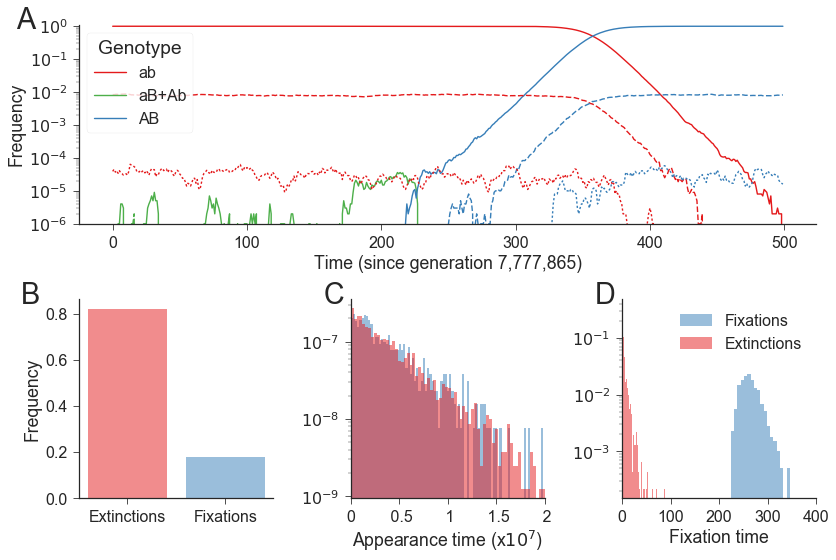

In [21]:
fig = plt.figure(figsize=(12, 8)) 
gs = mpl.gridspec.GridSpec(nrows=2, ncols=3)

ax0 = plt.subplot(gs[0, :])
ax1 = plt.subplot(gs[1, 1])
ax2 = plt.subplot(gs[1, 2])
ax3 = plt.subplot(gs[1, 0])

alpha = 0.5
tmax = Ws.size
t = np.arange(tmax - 500, tmax)
red, blue, green = sns.color_palette('Set1', 3)
colors = [red, green, blue]
lines_styles = ['solid', 'dashed', 'dotted']
panel_label_size=plt.rcParams[ 'axes.titlesize']*1.5

# frequency dynamics

genotypes = ['ab', 'aB+Ab', 'AB']

for load in range(3):
    for g in range(3):
        ax0.plot(np.arange(t.size), ps[t,g,load], color=colors[g], ls=lines_styles[load])

ax0.set(
    xlabel='Time (since generation {:,})'.format(tmax-500),
    ylabel='Frequency',
    yscale='log',
    ylim=(1/N, 1.1)
)
ax0.legend(genotypes, loc='upper left', title='Genotype', frameon=True)

# adaptation statistics

sns.distplot(df.app_time[df.fix], bins=100, kde=False, norm_hist=True, hist_kws=dict(log=True, alpha=alpha), color=blue, ax=ax1)
sns.distplot(df.app_time[~df.fix], bins=100, kde=False, norm_hist=True, hist_kws=dict(log=True, alpha=alpha), color=red, ax=ax1)

ax1.set(
    xlim=(0, 2e7),
    xticks=[0, 0.5e7, 1e7, 1.5e7, 2e7],
    xticklabels=r'0, 0.5, 1, 1.5, 2'.split(','),
    xlabel='Appearance time (x$10^7$)',
    ylabel=''
)

sns.distplot(df.fix_time[df.fix], bins=50, kde=False, norm_hist=True, hist_kws=dict(log=True, alpha=alpha), color=blue, ax=ax2)
sns.distplot(df.fix_time[~df.fix], bins=50, kde=False, norm_hist=True, hist_kws=dict(log=True, alpha=alpha), color=red, ax=ax2)
ax2.set(
    xlim=(0, 400),
    xlabel='Fixation time',
    ylabel=''
)
ax2.legend(['Fixations', 'Extinctions'], loc='best')

fix = df.fix.mean()
ext = (~df.fix).mean()
assert np.allclose(fix + ext, 1)

ax3.bar([0, 1], [ext, fix], color=[red, blue], alpha=alpha)
ax3.set(
    xticks=[0, 1],
    xticklabels=['Extinctions', 'Fixations'],
    xlabel='',
    ylabel='Frequency'
)                     

ax0.annotate('A', (-0.085, 0.98), xycoords='axes fraction', fontsize=panel_label_size)
ax3.annotate('B', (-0.3, 0.98), xycoords='axes fraction', fontsize=panel_label_size)
ax1.annotate('C', (-0.14, 0.98), xycoords='axes fraction', fontsize=panel_label_size)
ax2.annotate('D', (-0.14, 0.98), xycoords='axes fraction', fontsize=panel_label_size)

fig.tight_layout()
sns.despine()
fig.savefig('twolocus.tif', dpi=300)
fig.savefig('twolocus.pdf', dpi=300, paper_size='A4')

In [85]:
df.fix.size, df.fix.sum(), (~df.fix).sum()

(3246, 578, 2668)

# License

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.